In [358]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import pandas as pd
df= pd.read_csv('housing_prices.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [359]:
corr = df.corr()
corr_values = corr.unstack()
corr_values = corr_values.loc[corr_values!=1]
cvs=corr_values.sort_values(ascending=False)

cvs.head(10)


GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
1stFlrSF      TotalBsmtSF     0.819530
TotalBsmtSF   1stFlrSF        0.819530
SalePrice     OverallQual     0.790982
OverallQual   SalePrice       0.790982
dtype: float64

In [360]:
def define_y_and_X (df):
    y = df.pop('SalePrice')
    X = df.drop(columns=['Id'])
    return y, X
y, X = define_y_and_X(df)


In [361]:
def drop_corr_feat(X):
    # Create correlation matrix
    corr_matrix = X.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
    # Drop features 
    X = X.drop(columns=to_drop, axis=1)
    return X
X = drop_corr_feat(X)

<AxesSubplot:>

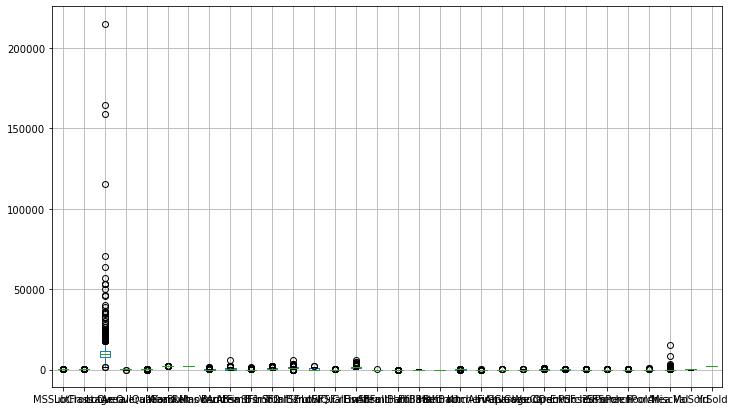

In [362]:
X.boxplot(figsize=['12', '7'])

In [363]:
def split_select (y, X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    num_cols = X_train.select_dtypes(include="number").columns
    cat_cols = X_train.select_dtypes(exclude="number").columns
    cat_data =  X_train.select_dtypes(exclude="number")
    return num_cols, cat_cols, cat_data, X_train, X_test, y_train, y_test
num_cols, cat_cols, cat_data, X_train, X_test, y_train, y_test = split_select (y, X)

In [364]:
selector = SelectFromModel(RandomForestRegressor(), threshold=None)
pca = PCA(n_components=4)

In [396]:
num_pipe = make_pipeline(SimpleImputer(strategy="median"))
cat_pipe = OneHotEncoder(handle_unknown="ignore", drop='first', sparse=False,)

# make the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipe', num_pipe, num_cols),
        ('cat_pipe', cat_pipe, cat_cols),
    ]
)

# make a pipeline
full_pipeline = make_pipeline(
                              preprocessor,
                              #StandardScaler(),
                              #RobustScaler(),
                              MinMaxScaler(),
                              #selector,
                              #pca,
                              GradientBoostingRegressor()).set_output(transform='pandas')
                              

# define a Parameter grid
boosti_param_grid = {
            'gradientboostingregressor__n_estimators': [300],
            'gradientboostingregressor__learning_rate': [ 0.1],
            'gradientboostingregressor__max_depth': [2, 3],
            'gradientboostingregressor__min_samples_split': [ 3, 5],
            'gradientboostingregressor__min_samples_leaf': [ 2, 4]
}





# define GridSearchCV
boosti_search = GridSearchCV(full_pipeline,
                      boosti_param_grid,
                      cv=5,
                      verbose=1)

In [397]:
boosti_search.fit(X_train, y_train)

boosti_search.best_score_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\leoos\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\leoos\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [10, 15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\leoos\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\leoos\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [10, 13, 14, 27, 31] during transform. These unknown categories will be encoded as all zeros

0.8745194532814935

In [398]:
boosti_search.best_params_

{'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__min_samples_leaf': 2,
 'gradientboostingregressor__min_samples_split': 5,
 'gradientboostingregressor__n_estimators': 300}

In [399]:
pred_train = boosti_search.predict(X_train)
pred_test = boosti_search.predict(X_test)

c:\Users\leoos\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [400]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [401]:
# Evaluate the model using MAE

train_mae_all = mean_absolute_error(y_train, pred_train)
test_mae_all = mean_absolute_error(y_test, pred_test)

print(f"Improved Model Train MAE: {train_mae_all:.2f}")
print(f"Improved Model Test MAE: {test_mae_all:.2f}")

Improved Model Train MAE: 6261.17
Improved Model Test MAE: 16282.89


#TESTING KAGGLE DATA

In [402]:
t_df = pd.read_csv('test.csv')

t_df['SalePrice'] = boosti_search.predict(t_df)

boosti_search.predict(t_df)

boosti_search.best_score_

c:\Users\leoos\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 5, 15, 16, 30, 31, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\leoos\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0, 5, 15, 16, 30, 31, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


0.8745194532814935

In [374]:
 #t_df[['Id', 'SalePrice']].to_csv('leo_kaggle_5.csv', index= None)